In [1]:
# IMPORT LIBRARIES
import os
import time
import pandas as pd
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import statsmodels.api as sm
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings("ignore") # Suppress warnings

plt.rcParams["figure.figsize"] = (15, 3)
plt.rcParams["lines.linewidth"] = 2

## 🔵 Data Preprocessing


### 🔃 Loading the dataset
 Import the dataset containing hourly energy consumption data for the PJM West Region.

In [2]:
DATA_DIR = 'data/'
dataset_filepath = DATA_DIR + 'PJMW_hourly.csv'
data = pd.read_csv(dataset_filepath)
data.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [3]:
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.head()

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [4]:
data.tail()

,PJMW_MW
Datetime,
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0
2018-08-02 23:00:00,5892.0
2018-08-03 00:00:00,5489.0


**Create a version of the dataset that is aggregated on the daily level**

In [5]:
data_daily = data.resample('D').mean()
data_daily

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000
...,...
2018-07-30,5492.708333
2018-07-31,5660.750000
2018-08-01,5959.708333


### 🔍 Data Exploration and Preprocessing

Plotting the daily electricity consumption data.

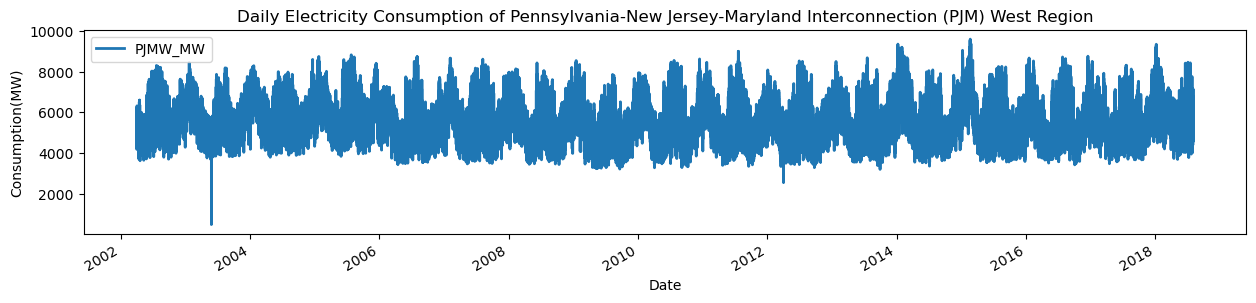

In [6]:
data.plot(
    title="Daily Electricity Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region",
    xlabel="Date",
    ylabel="Consumption(MW)",
)
plt.autoscale()
plt.show()

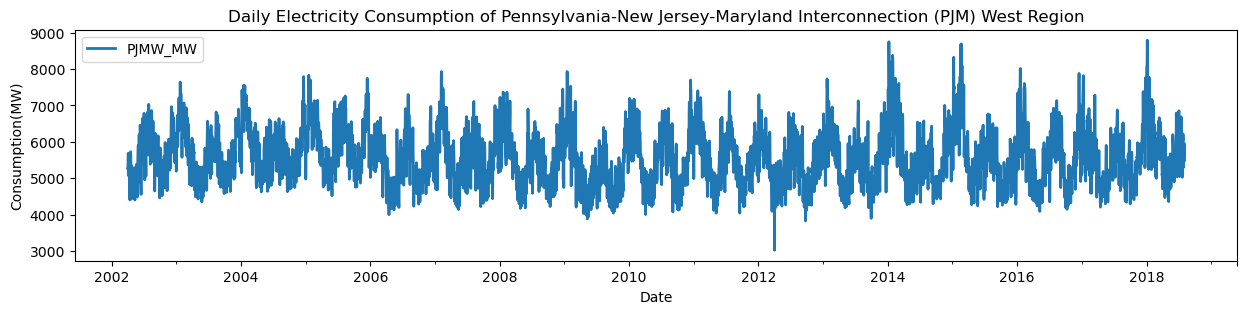

In [7]:
data_daily.plot(
    title="Daily Electricity Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region",
    xlabel="Date",
    ylabel="Consumption(MW)",
)
plt.autoscale()
plt.show()

Identify missing values with the hourly data and forward fill missing dates.

In [8]:
num_missval = None
num_missdates = None

# get all dates (in days) based on min and max dates in the dataset
dates = pd.date_range(start=data.index[0], end=data.index[-1], freq='H')
data = data[~data.index.duplicated(keep='first')]
data = data.reindex(dates, fill_value=None)

# get all dates (in days) based on min and max dates in the dataset
dates_daily = pd.date_range(start=data_daily.index[0], end=data_daily.index[-1], freq='D')
data_daily = data_daily[~data_daily.index.duplicated(keep='first')]
data_daily = data_daily.reindex(dates_daily, fill_value=None)

# create series with complete dates
ts = pd.Series(data=data['PJMW_MW'].values, index=dates)
ts = ts.round(2)  # round for nice printing

# create series with complete dates
ts_daily = pd.Series(data=data_daily['PJMW_MW'].values, index=dates_daily)
ts_daily = ts_daily.round(2)  # round for nice printing

# get number of dates with missing values
num_missval = ts.isnull().sum()
# get dates with missing values
num_missdates = ts.isnull()

# get number of dates with missing values
num_missval_daily = ts_daily.isnull().sum()
# get dates with missing values
num_missdates_daily = ts_daily.isnull()

In [9]:
num_missdates[num_missdates == True]

2002-04-07 03:00:00    True
2002-10-27 02:00:00    True
2003-04-06 03:00:00    True
2003-10-26 02:00:00    True
2004-04-04 03:00:00    True
2004-10-31 02:00:00    True
2005-04-03 03:00:00    True
2005-10-30 02:00:00    True
2006-04-02 03:00:00    True
2006-10-29 02:00:00    True
2007-03-11 03:00:00    True
2007-11-04 02:00:00    True
2008-03-09 03:00:00    True
2008-11-02 02:00:00    True
2009-03-08 03:00:00    True
2009-11-01 02:00:00    True
2010-03-14 03:00:00    True
2010-11-07 02:00:00    True
2010-12-10 00:00:00    True
2011-03-13 03:00:00    True
2011-11-06 02:00:00    True
2012-03-11 03:00:00    True
2012-11-04 02:00:00    True
2013-03-10 03:00:00    True
2013-11-03 02:00:00    True
2014-03-09 03:00:00    True
2015-03-08 03:00:00    True
2016-03-13 03:00:00    True
2017-03-12 03:00:00    True
2018-03-11 03:00:00    True
dtype: bool

In [10]:
num_missdates_daily[num_missdates_daily == True]

Series([], Freq: D, dtype: bool)

In [11]:
ts_filled = pd.DataFrame(index=ts.index)
ts_filled['PJMW_MW'] =  ts.ffill().values
ts_filled.isnull().sum()

PJMW_MW    0
dtype: int64

In [12]:
ts_filled.shape

(143232, 1)

In [13]:
ts_daily

2002-04-01    5271.17
2002-04-02    5310.42
2002-04-03    5325.92
2002-04-04    5670.79
2002-04-05    5686.12
               ...   
2018-07-30    5492.71
2018-07-31    5660.75
2018-08-01    5959.71
2018-08-02    5805.04
2018-08-03    5489.00
Freq: D, Length: 5969, dtype: float64

In [14]:
ts_filled_daily = pd.DataFrame(index=ts_daily.index)
ts_filled_daily['PJMW_MW'] =  ts_daily.ffill().values
ts_filled_daily.isnull().sum()

PJMW_MW    0
dtype: int64

In [15]:
ts_filled_daily.shape

(5969, 1)

In [16]:
ts_filled.describe()

,PJMW_MW
count,143232.000000
mean,5602.227805
std,979.165847
min,487.000000
25%,4906.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


In [17]:
ts_filled_daily.describe()

,PJMW_MW
count,5969.000000
mean,5602.278303
std,737.718840
min,3018.040000
25%,5043.880000
50%,5522.460000
75%,6086.000000
max,8794.580000


Plot the autocorrelation function (ACF) of the time series to analyze its correlations over different lag values.

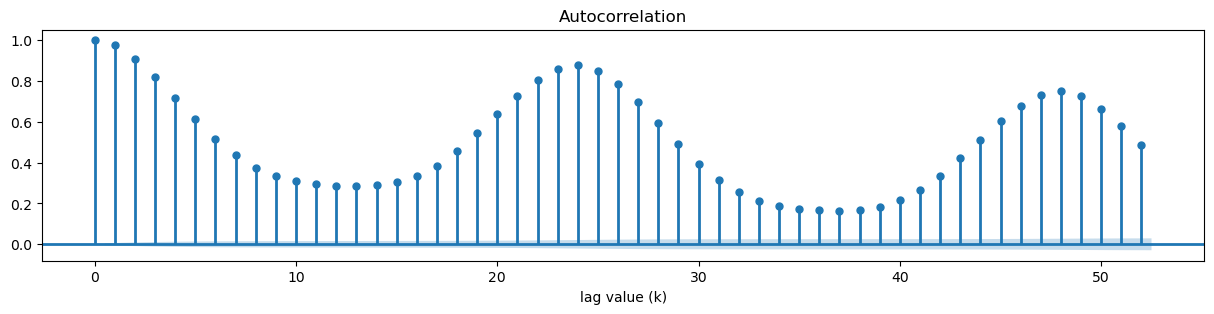

In [18]:
plot_acf(ts_filled)
plt.autoscale()
plt.xlabel("lag value (k)")
plt.show()

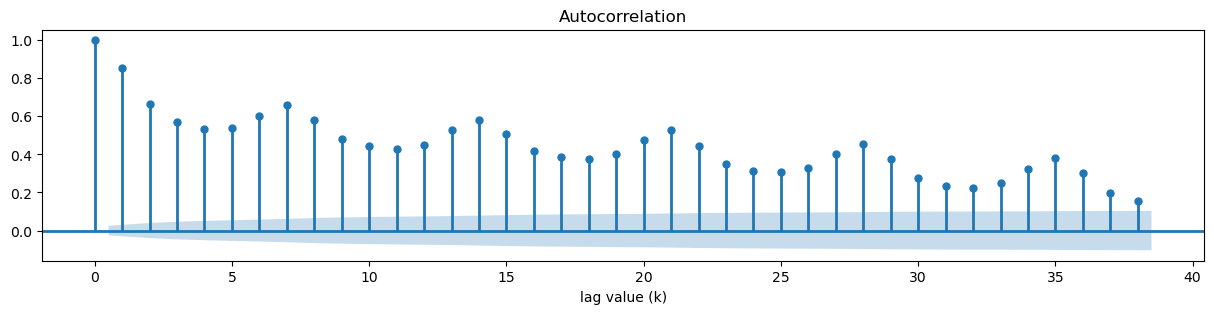

In [19]:
plot_acf(ts_filled_daily)
plt.autoscale()
plt.xlabel("lag value (k)")
plt.show()

On the hourly level, the autocorrelation function (ACF) indicates a 24-hour seasonality or daily in the time series data.

On the daily level, the autocorrelation function (ACF) indicates a 7-day seasonality or weekly in the time series data.

### 🔨 Prepare train/validation data

#### 🔀 Train Test Split

Defining parmaters:
- 24-hour daily pattern
- Target 30-day forecast horizon

In [20]:
m = 24 # 24 hour daily pattern
h = 24 * 30 #  One Month in Advance Forecast

m_daily = 7 # One week pattern
h_daily = 30 #  One Month in Advance Forecast

Prepare data for ARIMA by splitting the time series into 80% training and validation set and 20% test set. This will be used later for AutoML

In [21]:
test_size = round(ts_filled.shape[0] * 0.2) # 20% train-test split
ts_trainval = ts_filled[:-test_size]
ts_test = ts_filled[-test_size:]

In [22]:
test_size_daily = round(ts_filled_daily.shape[0] * 0.2) # 20% train-test split
ts_trainval_daily = ts_filled_daily[:-test_size_daily]
ts_test_daily = ts_filled_daily[-test_size_daily:]

Create a dataframe with lagged features and future values for ARIMA, then remove rows with missing values.

In [23]:
df_ts_multi = pd.DataFrame()

for i in range(1, m + 1):
  df_ts_multi['x' + str(i)] = ts_filled['PJMW_MW'].shift(i)

for i in range(0, h):
  df_ts_multi['y' + str(i + 1)] = ts_filled['PJMW_MW'].shift(-i)


df_ts_multi.dropna(inplace=True)
df_ts_multi.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y711,y712,y713,y714,y715,y716,y717,y718,y719,y720
2002-04-02 01:00:00,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,5425.0,...,5346.0,5291.0,5297.0,5262.0,5236.0,5294.0,5609.0,5528.0,5130.0,4673.0
2002-04-02 02:00:00,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,5346.0,...,5291.0,5297.0,5262.0,5236.0,5294.0,5609.0,5528.0,5130.0,4673.0,4392.0
2002-04-02 03:00:00,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,5272.0,...,5297.0,5262.0,5236.0,5294.0,5609.0,5528.0,5130.0,4673.0,4392.0,4251.0
2002-04-02 04:00:00,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,5323.0,...,5262.0,5236.0,5294.0,5609.0,5528.0,5130.0,4673.0,4392.0,4251.0,4214.0
2002-04-02 05:00:00,4737.0,4713.0,4768.0,4873.0,5038.0,5406.0,5783.0,5978.0,5954.0,5556.0,...,5236.0,5294.0,5609.0,5528.0,5130.0,4673.0,4392.0,4251.0,4214.0,4180.0


In [24]:
df_ts_multi_daily = pd.DataFrame()

for i in range(1, m_daily + 1):
  df_ts_multi_daily['x' + str(i)] = ts_filled_daily['PJMW_MW'].shift(i)

for i in range(0, h_daily):
  df_ts_multi_daily['y' + str(i + 1)] = ts_filled_daily['PJMW_MW'].shift(-i)


df_ts_multi_daily.dropna(inplace=True)
df_ts_multi_daily.head()

,x1,x2,x3,x4,x5,x6,x7,y1,y2,y3,...,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30
2002-04-08,5060.65,5367.79,5686.12,5670.79,5325.92,5310.42,5271.17,5283.88,5136.08,5171.67,...,4452.33,5221.67,5230.00,5112.75,5202.50,4975.12,4676.83,4461.88,5081.75,5194.12
2002-04-09,5283.88,5060.65,5367.79,5686.12,5670.79,5325.92,5310.42,5136.08,5171.67,5207.88,...,5221.67,5230.00,5112.75,5202.50,4975.12,4676.83,4461.88,5081.75,5194.12,5236.58
2002-04-10,5136.08,5283.88,5060.65,5367.79,5686.12,5670.79,5325.92,5171.67,5207.88,5090.42,...,5230.00,5112.75,5202.50,4975.12,4676.83,4461.88,5081.75,5194.12,5236.58,5290.38
2002-04-11,5171.67,5136.08,5283.88,5060.65,5367.79,5686.12,5670.79,5207.88,5090.42,4586.21,...,5112.75,5202.50,4975.12,4676.83,4461.88,5081.75,5194.12,5236.58,5290.38,5068.42
2002-04-12,5207.88,5171.67,5136.08,5283.88,5060.65,5367.79,5686.12,5090.42,4586.21,4401.33,...,5202.50,4975.12,4676.83,4461.88,5081.75,5194.12,5236.58,5290.38,5068.42,4525.25


#### 🔗 Neural Networks Data Preparation

Neural networks require a different data preparation approach.

The first step is normalizing the time series data for neural networks by subtracting the mean and dividing by the standard deviation.

In [25]:
# Normalization and Feature Engineer
ts_nn = ts_filled.copy()
ts_nn['DAY'] = ts_nn.index.dayofweek + 1
ts_nn['MONTH'] = ts_nn.index.month
ts_nn['YEAR_WEEK'] = ts_nn.index.isocalendar().week.astype(float)
ts_nn['YEAR_DAY'] = ts_nn.index.dayofyear.astype(float)
ts_nn.reset_index(drop=True, inplace=True)
ts_nn = ts_nn.values

mean = ts_nn.mean(axis=0)
ts_nn -= mean
std = ts_nn.std(axis=0)
ts_nn /= std

In [26]:
# Normalization and Feature Engineer
ts_nn_daily = ts_filled_daily.copy()
ts_nn_daily['DAY'] = ts_nn_daily.index.dayofweek + 1
ts_nn_daily['MONTH'] = ts_nn_daily.index.month
ts_nn_daily['YEAR_WEEK'] = ts_nn_daily.index.isocalendar().week.astype(float)
ts_nn_daily['YEAR_DAY'] = ts_nn_daily.index.dayofyear.astype(float)
ts_nn_daily.reset_index(drop=True, inplace=True)
ts_nn_daily = ts_nn_daily.values

mean_daily = ts_nn_daily.mean(axis=0)
ts_nn_daily -= mean_daily
std_daily = ts_nn_daily.std(axis=0)
ts_nn_daily /= std_daily

Set parameters for neural network training: a 3-day lookback period, 24-hour steps, a 30-day prediction delay, a batch size of 512, and the target index 0 for prediction.

In [27]:
lookback = 1 * 24 * 3 # 3 day look back
step = 1
delay = 30 * 24 # 30 days into the future
batch_size = 512
target_i = 0

In [28]:
lookback_daily = 30 # 30 day look back
step_daily = 1
delay_daily = 30# 30 days into the future
batch_size = 512
target_i = 0


Define a data generator for neural networks that creates batches of samples and targets for training. It handles sequential or shuffled data sampling, supports a 3-day lookback period, 30 day forecast horizon, and produces normalized data with the specified step size.

In [29]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=batch_size, step=step):
    # Set default max_index if not provided
    if max_index is None:
        max_index = len(data) - delay - 1

    # Start index for data sampling
    i = min_index + lookback

    # Infinite loop to generate samples indefinitely
    while True:
        # Shuffle data if required; otherwise, generate sequential batches
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback  # Reset index if it goes beyond the max index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        # Initialize numpy arrays to store samples and targets
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), delay))

        # Populate samples and targets arrays
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)  # Select indices for sample
            samples[j] = data[indices]  # Assign the sliced data to samples

            indices2 = range(rows[j], rows[j] + delay)  # Select indices for target
            targets[j] = data[:, target_i][indices2].reshape(-1) # Set the corresponding target

        # Yield a batch of samples and targets
        yield samples, targets


Split the normalized time series data into 20% test set, and the remaining 80% into training and validation sets, with the validation set being 20% of the training data.

In [30]:
test_size_nn = round(ts_nn.shape[0] * 0.2) # 20% train-test split
trainval_size_nn = ts_nn.shape[0] - test_size_nn
val_size_nn = round(trainval_size_nn * 0.2) # 20% train-val split
train_size_nn = trainval_size_nn - val_size_nn

In [31]:
test_size_nn_daily = round(ts_nn_daily.shape[0] * 0.2) # 20% train-test split
trainval_size_nn_daily = ts_nn_daily.shape[0] - test_size_nn_daily
val_size_nn_daily = round(trainval_size_nn_daily * 0.2) # 20% train-val split
train_size_nn_daily = trainval_size_nn_daily - val_size_nn_daily

In [32]:
train_gen = None
val_gen = None
test_gen = None

In [33]:
train_gen_daily = None
val_gen_daily = None
test_gen_daily = None

In [34]:
def init_generators(ts_nn, lookback, delay, train_size_nn,
                    trainval_size_nn, val_size_nn_daily, test_size):
  train_gen = generator(ts_nn,
      lookback=lookback,
      delay=delay,
      min_index=0,
      max_index=train_size_nn,
      shuffle=True,
      step=step,
      batch_size=batch_size)

  val_gen = generator(ts_nn,
      lookback=lookback,
      delay=delay,
      min_index=train_size_nn + 1,
      max_index=trainval_size_nn,
      shuffle=False,
      step=step,
      batch_size=batch_size)

  val_steps = val_size_nn - lookback

  test_gen = generator(ts_nn,
      lookback=lookback,
      delay=delay,
      min_index=trainval_size_nn + 1,
      max_index=None,
      step=step,
      batch_size=batch_size)

  test_steps = test_size - lookback
  return train_gen, val_gen, test_gen, val_steps, test_steps

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [36]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

NameError: name 'X_train' is not defined

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

## 🔵 Benchmarks


### 📐 Naive and Seasonal Naive Benchmarks

Set up benchmarks by splitting the data into training and test sets, preparing inputs and targets for model evaluation. Naive and Seasonal Naive methods are used as baseline benchmarks. The Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) are calculated for these methods, and the results are visualized against the true values.

In [37]:
df_train = df_ts_multi[:-test_size]
df_test = df_ts_multi[-test_size:]

targets  = [f'y{i+1}' for i in range(h)]

x_train  = df_train.drop(targets, axis=1).to_numpy()
y_train  = df_train[targets].to_numpy()

x_test   = df_test.drop(targets, axis=1).to_numpy()
y_test  = df_test[targets].to_numpy()

In [38]:
df_train_daily = df_ts_multi_daily[:-test_size_daily]
df_test_daily = df_ts_multi_daily[-test_size_daily:]

targets_daily  = [f'y{i+1}' for i in range(h_daily)]

x_train_daily  = df_train_daily.drop(targets_daily, axis=1).to_numpy()
y_train_daily  = df_train_daily[targets_daily].to_numpy()

x_test_daily   = df_test_daily.drop(targets_daily, axis=1).to_numpy()
y_test_daily  = df_test_daily[targets_daily].to_numpy()

In [39]:
y_naive =  np.tile(np.flip(x_test, axis=1)[:, -1:], h)
y_s_naive =  np.tile(np.flip(x_test, axis=1), (h//m))
y_true = y_test

print(f'Test MAE = {mean_absolute_error(y_true, y_naive):.4f} - Naive')
print(f'Test MAPE = {mean_absolute_percentage_error(y_true, y_naive) * 100:.4f} - Naive')
print(f'Test MAE = {mean_absolute_error(y_true, y_s_naive):.4f} - Seasonal Naive')
print(f'Test MAPE = {mean_absolute_percentage_error(y_true, y_s_naive) * 100:.4f} - Seasonal Naive')

Test MAE = 956.5599 - Naive
Test MAPE = 17.5711 - Naive
Test MAE = 674.8447 - Seasonal Naive
Test MAPE = 12.0972 - Seasonal Naive


In [40]:
y_naive_daily =  np.tile(np.flip(x_test_daily, axis=1)[:, -1:], h_daily)
y_s_naive_daily =  np.tile(np.flip(x_test_daily, axis=1), (h_daily//m_daily))
y_true_daily = y_test_daily

print(f'Test MAE = {mean_absolute_error(y_true_daily, y_naive_daily):.4f} - Naive')
print(f'Test MAPE = {mean_absolute_percentage_error(y_true_daily, y_naive_daily) * 100:.4f} - Naive')
print(f'Test MAE = {mean_absolute_error(y_true_daily[:, :28], y_s_naive_daily):.4f} - Seasonal Naive')
print(f'Test MAPE = {mean_absolute_percentage_error(y_true_daily[:, :28], y_s_naive_daily) * 100:.4f} - Seasonal Naive')

Test MAE = 621.9305 - Naive
Test MAPE = 11.1765 - Naive
Test MAE = 595.5008 - Seasonal Naive
Test MAPE = 10.6058 - Seasonal Naive


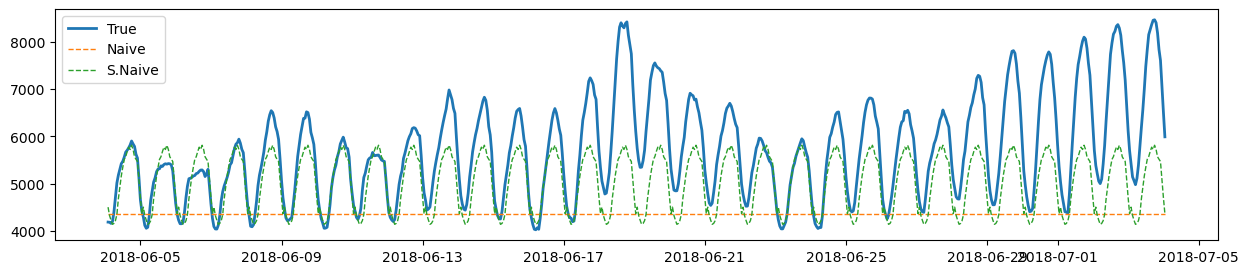

In [41]:
plt.plot(df_test.index[-720:], y_true[-720], label='True')
plt.plot(df_test.index[-720:], y_naive[-720], label='Naive', linestyle='--', linewidth=1)
plt.plot(df_test.index[-720:], y_s_naive[-720], label='S.Naive',linestyle='--', linewidth=1)
plt.legend()
plt.show()

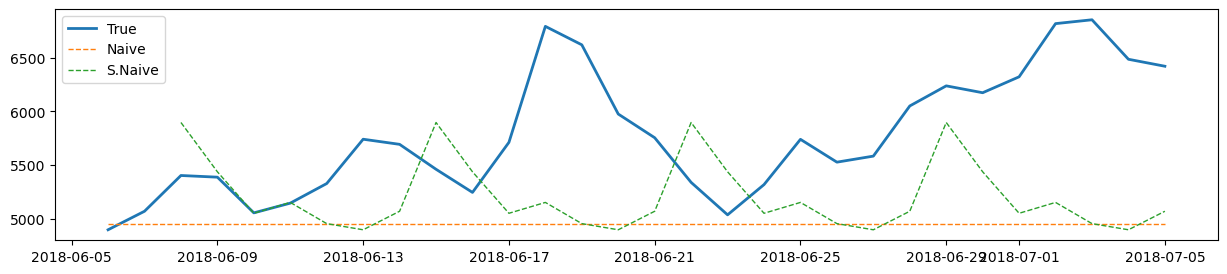

In [42]:
plt.plot(df_test_daily.index[-30:], y_true_daily[-30], label='True')
plt.plot(df_test_daily.index[-30:], y_naive_daily[-30], label='Naive', linestyle='--', linewidth=1)
plt.plot(df_test_daily.index[-28:], y_s_naive_daily[-28], label='S.Naive',linestyle='--', linewidth=1)
plt.legend()
plt.show()

The ARIMA model is a time series forecasting method combining three elements: AutoRegressive (AR) for past values, Integrated (I) for trend removal, and Moving Average (MA) for past errors. It is typically used to predict future data points by analyzing patterns in the historical data.

In [ ]:
# Log and Seasonal Differencing
class TimeseriesDifferencer:
    """Handles log transformation and seasonal differencing for time series data."""
    def __init__(self):
        self.x = None
        self.d = 0
    def fit(self, x, d):
        """Applies log transformation and differencing to make data stationary."""
        self.x = x
        self.d = d
        return np.log(x).diff(d)[d:]

    def reverse(self, pred, h):
        """Reverses differencing and log transformation on predicted values."""
        if h >= self.d:
          return np.exp(np.log(self.x[-h:]).to_numpy().flatten() + pred)
        else:
          return np.exp(np.log(self.x[-self.d:-self.d + h]).to_numpy().flatten() + pred)


Grid search is conducted to optimize ARIMA parameters using time series cross-validation. The process includes applying differencing, fitting ARIMA models, forecasting, and calculating error metrics (MAE, RMSE, MAPE) for each parameter combination.

In [ ]:
def auto_arima(ts_trainval, m, h, tskfold):
  p_grid = range(2)
  d_grid = range(1)
  q_grid = range(2)
  pdq_grid = list(itertools.product(p_grid, d_grid, q_grid))

  avg_mae  = []
  std_mae  = []
  avg_rmse = []
  std_rmse  = []
  avg_mape = []
  std_mape  = []
  for pdq in tqdm(pdq_grid):
      mae = []
      rmse = []
      mape = []
      for train_index, val_index in tskfold.split(ts_trainval):
          # train-val split
          x_train = ts_trainval.iloc[train_index]
          y_val = ts_trainval.iloc[val_index]

          # log, s.diff
          ts_diff = TimeseriesDifferencer()
          differenced = ts_diff.fit(x_train, m)
          ts_d = pd.DataFrame(index=differenced.index)
          ts_d['PJMW_MW'] = differenced.values

          models = {}
          for column in x_train.columns:
              model = ARIMA(ts_d[column], order=pdq).fit()
              models[column] = model

          # Multi-step forecasting
          forecasts = {}
          for column in x_train.columns:
              forecast = models[column].get_forecast(steps=h)
              forecasts[column] = forecast.predicted_mean

          for column in x_train.columns:
            rmse_value = mean_squared_error(y_val[column], ts_diff.reverse(forecasts[column], h), squared=False)
            mae_value = mean_absolute_error(y_val[column], ts_diff.reverse(forecasts[column], h))
            mape_value = mean_absolute_percentage_error(y_val[column], ts_diff.reverse(forecasts[column], h))

            # compile error
            mae.append(mae_value)
            rmse.append(rmse_value)
            mape.append(mape_value)

      # avg error
      avg_mae.append(np.mean(mae))
      std_mae.append(np.std(mae))
      avg_rmse.append(np.mean(rmse))
      std_rmse.append(np.std(rmse))
      avg_mape.append(np.mean(mape))
      std_mape.append(np.std(mape))

  df_results = pd.DataFrame()
  df_results['(p,d,q)'] = pdq_grid

  df_results['Avg. MAE'] = avg_mae
  df_results['Std. MAE'] = std_mae
  df_results['Avg. RMSE'] = avg_rmse
  df_results['Std. RMSE'] = std_rmse
  df_results['Avg. MAPE'] = [x * 100 for x in avg_mape]
  df_results['Std. MAPE'] = [x * 100 for x in std_mape]
  display(df_results.sort_values(by='Avg. MAPE').head(5))

In [ ]:
auto_arima(ts_trainval, m, h, tskfold = TimeSeriesSplit(n_splits=3, test_size=h))

In [ ]:
auto_arima(ts_trainval_daily, m_daily, h_daily, tskfold = TimeSeriesSplit(n_splits=3, test_size=h_daily))

The best ARIMA parameters, based on MAE and MAPE, are (p,d,q)=(0,0,0).

#### ✅ Results


Apply the best ARIMA model (0,0,0) to forecast future values and evaluate performance using MAE and MAPE. Forecasting is done in batches to handle the test set, and results are compared with the actual values.

In [ ]:
def my_arima(ts_trainval, ts_test, h, m, delay):
  ts_diff = TimeseriesDifferencer()
  differenced = ts_diff.fit(ts_trainval, m)
  ts_d = pd.DataFrame(index=differenced.index)
  ts_d['PJMW_MW'] = differenced.values

  # Best Model from above
  model = ARIMA(ts_d['PJMW_MW'], order=(0,0,0)).fit()
  forecast = model.get_forecast(steps=h)
  predictions = ts_diff.reverse(forecast.predicted_mean, h)

  # Forecast in batches
  predictions_batched = []
  for i in range(0, len(ts_test), h):
      batch_end = min(i + h, len(ts_test))  # Handle the last batch which might be smaller
      forecast = model.get_forecast(steps=batch_end - i)
      batch_predictions = ts_diff.reverse(forecast.predicted_mean, batch_end - i)
      predictions_batched.extend(batch_predictions)

  predictions_batched = np.array(predictions_batched)  # Convert to numpy array

  # Now evaluate the model
  mae = mean_absolute_error(ts_test['PJMW_MW'], predictions_batched)
  mape = mean_absolute_percentage_error(ts_test['PJMW_MW'], predictions_batched)

  print(f'Test MAE = {mae:.4f}')
  print(f'Test MAPE = {mape * 100:.4f}')

  # Plot the last 720 days (same range as the Benchmarks)
  plt.plot(
      ts_test['PJMW_MW'][-delay * 2: -delay].index,
      ts_test['PJMW_MW'][-delay * 2: -delay].values,
      label='True')
  plt.plot(
      ts_test['PJMW_MW'][-delay * 2: -delay].index,
      predictions_batched[-delay * 2: -delay],
      label='Predicted', linestyle='--',
      linewidth=2)
  plt.legend()
  plt.show()

In [ ]:
my_arima(ts_trainval, ts_test, h, m, delay)

In [ ]:
my_arima(ts_trainval_daily, ts_test_daily, h_daily, m_daily, delay_daily)

LSTM models for time series forecasting handle complex temporal patterns by learning from sequential data.

In [ ]:
train_gen, val_gen, test_gen, val_steps, test_steps = init_generators(ts_nn, lookback, delay, train_size_nn,
                    trainval_size_nn, val_size_nn, test_size)

In [ ]:
train_gen_daily, val_gen_daily, test_gen_daily, val_steps_daily, test_steps_daily = init_generators(
    ts_nn_daily, lookback_daily, delay_daily, train_size_nn_daily,
    trainval_size_nn_daily, val_size_nn_daily, test_size_daily)

In [ ]:
lstm_model = Sequential()
lstm_model.add(layers.LSTM(
    64,
    activation="tanh",
    dropout=0.15,
    recurrent_dropout=0.15,
    return_sequences=True,
    input_shape=(None, ts_nn.shape[-1])))
lstm_model.add(layers.LSTM(
    16,
    activation="tanh"))
lstm_model.add(layers.Dense(delay))
lstm_model.summary()

lstm_model.compile(optimizer="adam", loss='mae')
lstm_history = lstm_model.fit(train_gen,
                    steps_per_epoch=train_size_nn // batch_size,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_size_nn // batch_size)

PJMW_LSTM_JSON = HOME_DIR + "PJMW_LSTM.json"
PJMW_LSTM_H5 = HOME_DIR + "PJMW_LSTM.weights.h5"

save_model(lstm_model, PJMW_LSTM_JSON, PJMW_LSTM_H5)

plot_train_val_loss(lstm_history, 'LSTM')

json_file = open(PJMW_LSTM_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)

# load weights into new model
lstm_model.load_weights(PJMW_LSTM_H5)
print("Loaded model from disk")

train_gen, val_gen, test_gen, val_steps, test_steps = init_generators(
    ts_nn, lookback, delay, train_size_nn,
    trainval_size_nn, val_size_nn, test_size)
num_test_steps = test_size // batch_size
validate_model(lstm_model, test_gen, num_test_steps, delay)

**Do it again for the daily aggregated version**

In [ ]:
lstm_model = Sequential()
lstm_model.add(layers.LSTM(
    64,
    activation="tanh",
    dropout=0.15,
    recurrent_dropout=0.15,
    return_sequences=True,
    input_shape=(None, ts_nn_daily.shape[-1])))
lstm_model.add(layers.LSTM(
    16,
    activation="tanh"))
lstm_model.add(layers.Dense(delay_daily))
lstm_model.summary()

lstm_model.compile(optimizer="adam", loss='mae')
lstm_history = lstm_model.fit(train_gen_daily,
                    steps_per_epoch=train_size_nn_daily // batch_size,
                    epochs=10,
                    validation_data=val_gen_daily,
                    validation_steps=val_size_nn_daily // batch_size)

PJMW_LSTM_JSON = HOME_DIR + "PJMW_LSTM_daily.json"
PJMW_LSTM_H5 = HOME_DIR + "PJMW_LSTM_daily.weights.h5"

save_model(lstm_model, PJMW_LSTM_JSON, PJMW_LSTM_H5)

plot_train_val_loss(lstm_history, 'LSTM')

json_file = open(PJMW_LSTM_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)

# load weights into new model
lstm_model.load_weights(PJMW_LSTM_H5)
print("Loaded model from disk")

train_gen_daily, val_gen_daily, test_gen_daily, val_steps_daily, test_steps_daily = init_generators(
    ts_nn_daily, lookback_daily, delay_daily, train_size_nn_daily,
    trainval_size_nn_daily, val_size_nn_daily, test_size_daily)
num_test_steps = test_size_daily // batch_size
validate_model(lstm_model, test_gen_daily, num_test_steps, delay_daily)

In [ ]:
train_gen, val_gen, test_gen, val_steps, test_steps = init_generators(ts_nn, lookback, delay, train_size_nn,
                    trainval_size_nn, val_size_nn, test_size)

In [ ]:
train_gen_daily, val_gen_daily, test_gen_daily, val_steps_daily, test_steps_daily = init_generators(
    ts_nn_daily, lookback_daily, delay_daily, train_size_nn_daily,
    trainval_size_nn_daily, val_size_nn_daily, test_size_daily)

In [ ]:
gru_model = Sequential()
gru_model.add(layers.GRU(128,
                    activation="relu",
                    return_sequences=True,
                    input_shape=(None, ts_nn.shape[-1])))
gru_model.add(layers.GRU(32,
                    activation="relu"))
gru_model.add(layers.Dense(delay))
gru_model.summary()

gru_model.compile(optimizer="adam", loss='mae')
gru_history = gru_model.fit(train_gen,
                    steps_per_epoch=train_size_nn // batch_size,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_size_nn // batch_size)

PJMW_GRU_JSON = HOME_DIR + "PJMW_GRU.json"
PJMW_GRU_H5 = HOME_DIR + "PJMW_GRU.weights.h5"

save_model(gru_model, PJMW_GRU_JSON, PJMW_GRU_H5)

plot_train_val_loss(gru_history, 'GRU')

json_file = open(PJMW_GRU_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
gru_model = model_from_json(loaded_model_json)

# load weights into new model
gru_model.load_weights(PJMW_GRU_H5)
print("Loaded model from disk")

train_gen, val_gen, test_gen, val_steps, test_steps = init_generators(ts_nn, lookback, delay, train_size_nn,
                    trainval_size_nn, val_size_nn, test_size)
num_test_steps = test_size // batch_size
validate_model(gru_model, test_gen, num_test_steps, delay)

**Do it again for the daily aggregated version**

In [ ]:
gru_model = Sequential()
gru_model.add(layers.GRU(128,
                    activation="relu",
                    return_sequences=True,
                    input_shape=(None, ts_nn_daily.shape[-1])))
gru_model.add(layers.GRU(32,
                    activation="relu"))
gru_model.add(layers.Dense(delay_daily))
gru_model.summary()

gru_model.compile(optimizer="adam", loss='mae')
gru_history = gru_model.fit(train_gen_daily,
                    steps_per_epoch=train_size_nn_daily // batch_size,
                    epochs=10,
                    validation_data=val_gen_daily,
                    validation_steps=val_size_nn_daily // batch_size)

PJMW_GRU_JSON = HOME_DIR + "PJMW_GRU_daily.json"
PJMW_GRU_H5 = HOME_DIR + "PJMW_GRU_daily.weights.h5"

save_model(gru_model, PJMW_GRU_JSON, PJMW_GRU_H5)

plot_train_val_loss(gru_history, 'GRU')

json_file = open(PJMW_GRU_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
gru_model = model_from_json(loaded_model_json)

# load weights into new model
gru_model.load_weights(PJMW_GRU_H5)
print("Loaded model from disk")

train_gen_daily, val_gen_daily, test_gen_daily, val_steps_daily, test_steps_daily = init_generators(
    ts_nn_daily, lookback_daily, delay_daily, train_size_nn_daily,
    trainval_size_nn_daily, val_size_nn_daily, test_size_daily)
num_test_steps = test_size_daily // batch_size
validate_model(gru_model, test_gen_daily, num_test_steps, delay_daily)